In [110]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
mp.mp.dps = 50 #higher precision
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from plotDensity import *

In [2]:

#Keep having issues with check energy ranges. Currently only using seeds that worked
#Probably issue of having conflicting preruns?
batch_results_8 = []
for seed in range(100, 448):
    res = []
    all_good = True
    try:
        for error in ["I","X","Y","Z"]:
            filename = "../results/periodic/prob_0.107000/X_8_Y_8/seed_%d"%seed+"/error_class_"+error+"/intervals_5_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
            res.append(read_data_from_file(filename))
    except:
        try:
            for error in ["I","X","Y","Z"]:
                filename = "../results/periodic/prob_0.107000/X_8_Y_8/seed_%d"%seed+"/error_class_"+error+"/intervals_3_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
                res.append(read_data_from_file(filename))
        except:
            print('One or more error classes at 8 by 8 had an issue for seed',seed)
            all_good = False
    
    if all_good:
        batch_results_8.append(res)
        
        
batch_results_10 = []
for seed in range(100, 448):
    res = []
    all_good = True
    try:
        for error in ["I","X","Y","Z"]:
            filename = "../results/periodic/prob_0.107000/X_10_Y_10/seed_%d"%seed+"/error_class_"+error+"/intervals_5_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
            res.append(read_data_from_file(filename))
    except:
        try:
            for error in ["I","X","Y","Z"]:
                filename = "../results/periodic/prob_0.107000/X_10_Y_10/seed_%d"%seed+"/error_class_"+error+"/intervals_3_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
                res.append(read_data_from_file(filename))
        except:
            print('One or more error classes at 10 by 10 had an issue for seed',seed)
            all_good = False
    
    if all_good:
        batch_results_10.append(res)      
        
    
#Log sum exp with arbitrary precision
#Gives infinite temperature version of the free energy, for scaling
#Also useful later on
def log_sum_exp(to_sum):  
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return res


def free_energy(E_list, log_g_list,  T):
    #Need to log sum over g(E)*exp(-E/T) without overflow issues   
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res

def get_free_energies(rescaled_results,temperatures):
    free_energies = []
    for seed_results in rescaled_results:
        free_energy_classes = []
        for error_result in seed_results:    
            f_values = []
            for T in temperatures:
                f_values.append(free_energy(error_result[0], error_result[1], T)/(-T))
            free_energy_classes.append(f_values)
        free_energies.append(free_energy_classes)
    return free_energies

    
def process_results(batch_results,X,Y):
    rescaled_results = []
    for seed_results in batch_results:
                
        rescaled_seed_results = []
        for error_result in seed_results:    
                        
            walker_results = error_result
            walker_results = get_renormalized_log_g_values_as_dict_list(walker_results)
            walker_results = average_matching_keys(walker_results)
            results_x = []
            results_y = []
            for result in walker_results:
                results_y.append(np.array(list(result.values())))
                results_x.append(np.array(list(result.keys())))
                
            derivatives_wrt_e = get_derivative_wrt_e(walker_results)
            minimum_deviation_energies = find_lowest_inverse_temp_deviation(derivatives_wrt_e)
            rescale_results_for_concatenation(results_x, results_y, minimum_deviation_energies)
            
            x_max = -1 -2*X*Y
            rescaled_x = []
            rescaled_y = []
            for i in range(len(results_x)):
                for j in range(len(results_x[i])):
                    if results_x[i][j] > x_max: #avoid double counting
                        x_max = results_x[i][j]
                        rescaled_x.append(results_x[i][j])
                        rescaled_y.append(results_y[i][j])

            offset = log_sum_exp(rescaled_y)
            rescaled_y = [res + mp.log(2)*X*Y - offset for res in rescaled_y]
            rescaled_seed_results.append([rescaled_x,rescaled_y])
        rescaled_results.append(rescaled_seed_results)
    return rescaled_results
            
rescaled_results_8 = process_results(batch_results_8,8,8)
rescaled_results_10 = process_results(batch_results_10,10,10)

One or more error classes at 8 by 8 had an issue for seed 123
One or more error classes at 8 by 8 had an issue for seed 129


In [3]:
batch_results_12 = []
for seed in range(100, 400):
    res = []
    all_good = True
    try:
        for error in ["I","X","Y","Z"]:
            filename = "../results/periodic/prob_0.107000/X_12_Y_12/seed_%d"%seed+"/error_class_"+error+"/intervals_20_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
            res.append(read_data_from_file(filename))
    except:
        print('One or more error classes at 12 by 12 had an issue for seed',seed)
        all_good = False
    
    if all_good:
        batch_results_12.append(res)
        

        
batch_results_14 = []
for seed in range(100, 400):
    res = []
    all_good = True
    try:
        for error in ["I","X","Y","Z"]:
            filename = "../results/periodic/prob_0.107000/X_14_Y_14/seed_%d"%seed+"/error_class_"+error+"/intervals_20_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
            res.append(read_data_from_file(filename))
    except:
        print('One or more error classes at 14 by 14 had an issue for seed',seed)
        all_good = False
    
    if all_good:
        batch_results_14.append(res)
        
rescaled_results_12 = process_results(batch_results_12,12,12)
rescaled_results_14 = process_results(batch_results_14,14,14)

One or more error classes at 14 by 14 had an issue for seed 125
One or more error classes at 14 by 14 had an issue for seed 153
One or more error classes at 14 by 14 had an issue for seed 175
One or more error classes at 14 by 14 had an issue for seed 280
One or more error classes at 14 by 14 had an issue for seed 398


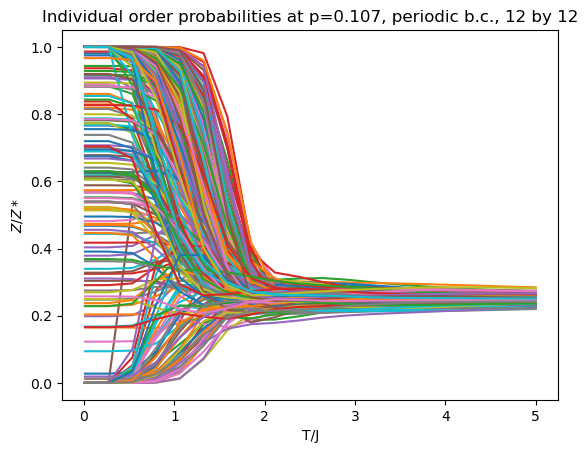

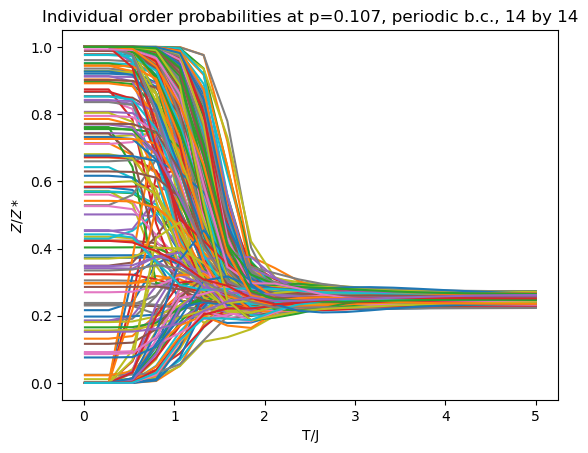

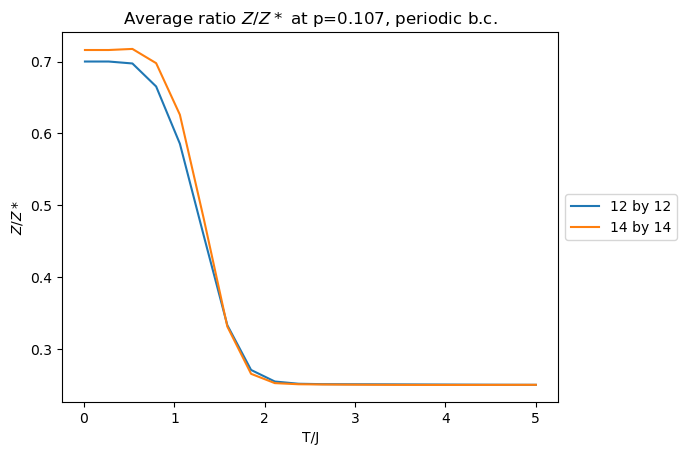

In [4]:
max_temp = 5

temperatures = np.linspace(0.01,max_temp,20)
free_energies_12 = get_free_energies(rescaled_results_12,temperatures)
free_energies_14 = get_free_energies(rescaled_results_14,temperatures)

plt.figure() 
for f_class in free_energies_12:
    plt.plot(temperatures, [1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                              +mp.exp(f_class[2][j] - f_class[0][j])\
                              +mp.exp(f_class[3][j] - f_class[0][j])) \
                            for j in range(len(f_class[0]))])
plt.title("Individual order probabilities at p=0.107, periodic b.c., 12 by 12")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.show()

plt.figure() 
for f_class in free_energies_14:
    plt.plot(temperatures, [1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                              +mp.exp(f_class[2][j] - f_class[0][j])\
                              +mp.exp(f_class[3][j] - f_class[0][j])) \
                            for j in range(len(f_class[0]))])
plt.title("Individual order probabilities at p=0.107, periodic b.c., 14 by 14")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.show()



plt.figure() 
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_12 ])/len(free_energies_12)  \
                        for j in range(len(f_class[0]))], label="12 by 12")
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_14 ])/len(free_energies_14)  \
                        for j in range(len(f_class[0]))], label="14 by 14")
plt.title(r"Average ratio $Z/Z*$ at p=0.107, periodic b.c.")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

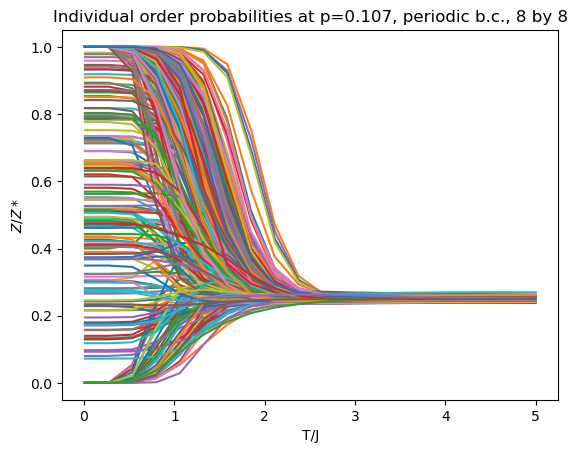

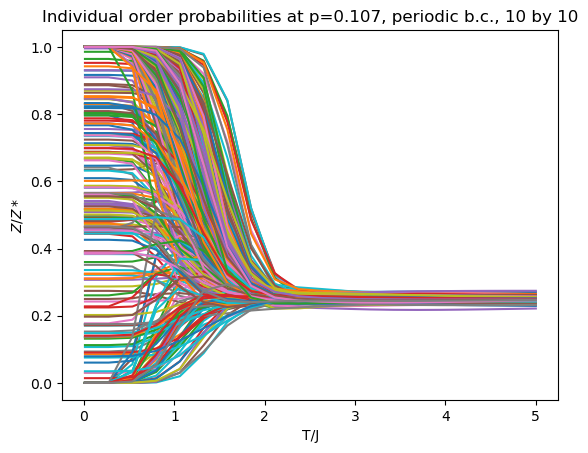

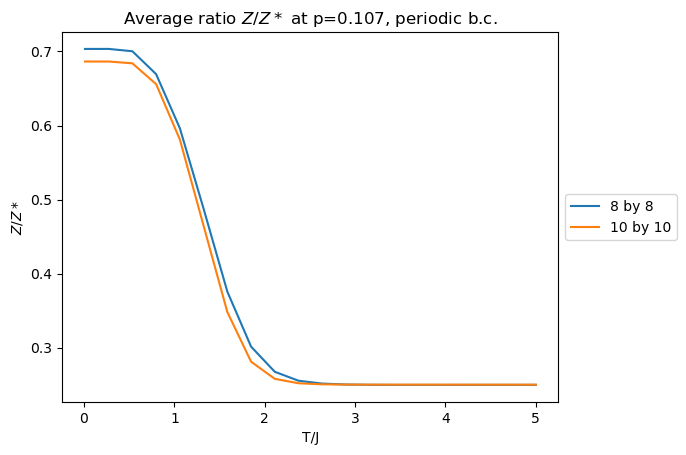

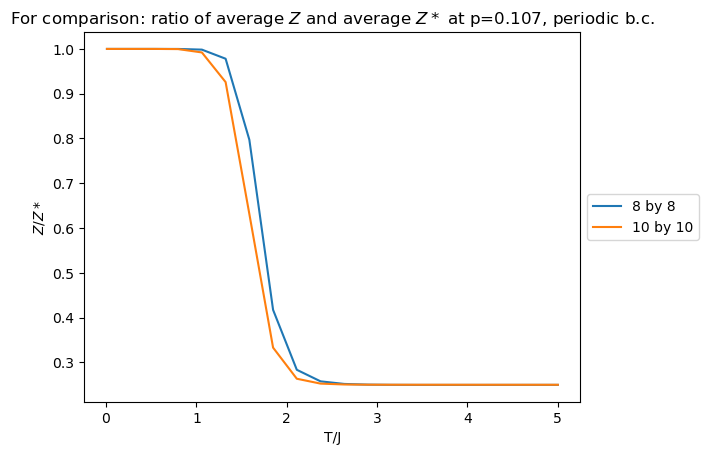

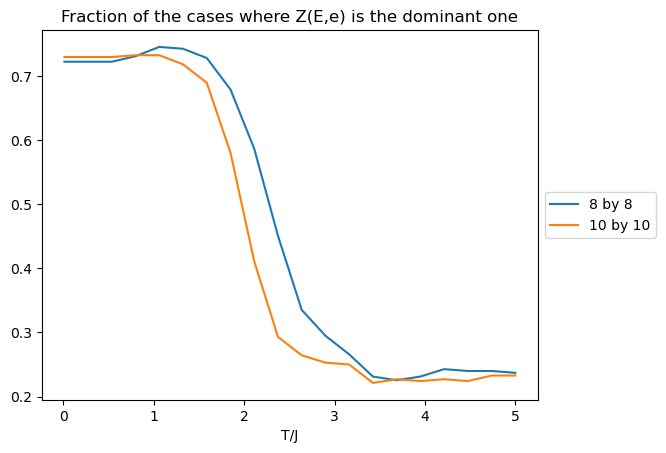

In [5]:
temperatures = np.linspace(0.01,max_temp,20)
free_energies_8 = get_free_energies(rescaled_results_8,temperatures)
free_energies_10 = get_free_energies(rescaled_results_10,temperatures)

plt.figure() 
for f_class in free_energies_8:
    plt.plot(temperatures, [1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                              +mp.exp(f_class[2][j] - f_class[0][j])\
                              +mp.exp(f_class[3][j] - f_class[0][j])) \
                            for j in range(len(f_class[0]))])
plt.title("Individual order probabilities at p=0.107, periodic b.c., 8 by 8")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.show()

plt.figure() 
for f_class in free_energies_10:
    plt.plot(temperatures, [1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                              +mp.exp(f_class[2][j] - f_class[0][j])\
                              +mp.exp(f_class[3][j] - f_class[0][j])) \
                            for j in range(len(f_class[0]))])
plt.title("Individual order probabilities at p=0.107, periodic b.c., 10 by 10")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.show()


####################
# We check the average of the ratio of Z

plt.figure() 
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_8 ])/len(free_energies_8)  \
                        for j in range(len(f_class[0]))], label="8 by 8")
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_10 ])/len(free_energies_10)  \
                        for j in range(len(f_class[0]))], label="10 by 10")
plt.title(r"Average ratio $Z/Z*$ at p=0.107, periodic b.c.")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#We also want to check the order probability of the average, ie ratio of average Z

plt.figure()

f_class = free_energies_8[0]

average_I = [log_sum_exp([f_class[0][j] for f_class in free_energies_8])  for j in range(len(f_class[0]))]
average_X = [log_sum_exp([f_class[1][j] for f_class in free_energies_8])  for j in range(len(f_class[0]))]
average_Y = [log_sum_exp([f_class[2][j] for f_class in free_energies_8])  for j in range(len(f_class[0]))]
average_Z = [log_sum_exp([f_class[3][j] for f_class in free_energies_8])  for j in range(len(f_class[0]))]
average_all = [log_sum_exp([average_I[j],average_X[j],average_Y[j],average_Z[j]]) for j in range(len(average_I))]

plt.plot(temperatures, [mp.exp(average_I[j] - average_all[j]) for j in range(len(average_I))],label="8 by 8")


f_class = free_energies_10[0]

average_I = [log_sum_exp([f_class[0][j] for f_class in free_energies_10])  for j in range(len(f_class[0]))]
average_X = [log_sum_exp([f_class[1][j] for f_class in free_energies_10])  for j in range(len(f_class[0]))]
average_Y = [log_sum_exp([f_class[2][j] for f_class in free_energies_10])  for j in range(len(f_class[0]))]
average_Z = [log_sum_exp([f_class[3][j] for f_class in free_energies_10])  for j in range(len(f_class[0]))]
average_all = [log_sum_exp([average_I[j],average_X[j],average_Y[j],average_Z[j]]) for j in range(len(average_I))]

plt.plot(temperatures, [mp.exp(average_I[j] - average_all[j]) for j in range(len(average_I))],label="10 by 10")

plt.title(r"For comparison: ratio of average $Z$ and average $Z*$ at p=0.107, periodic b.c.")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


############
#For comparison, we also count how often any individual ratio is off.

plt.figure()
plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_8])/(len(free_energies_8))\
                        for j in range(len(f_class[0])) ] , label = "8 by 8")
plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_10])/(len(free_energies_10))\
                        for j in range(len(f_class[0])) ] , label = "10 by 10")
plt.title("Fraction of the cases where Z(E,e) is the dominant one")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


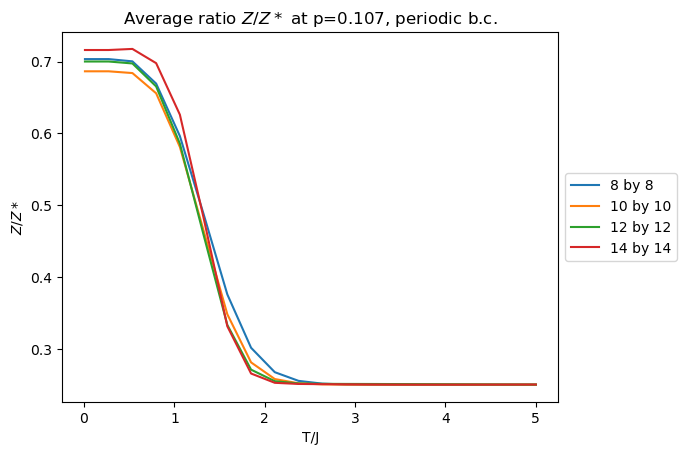

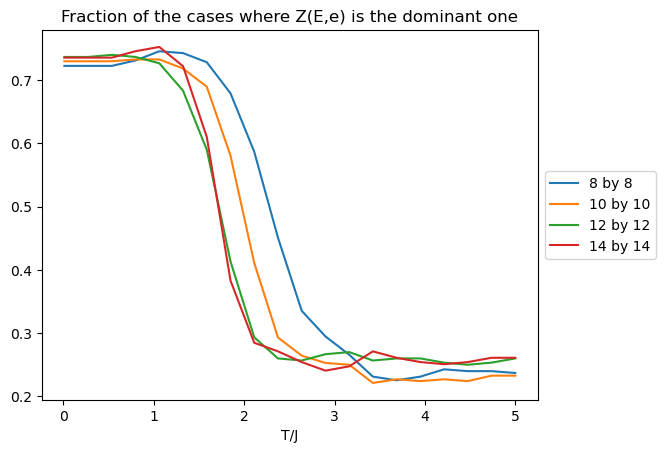

In [6]:
plt.figure() 
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_8 ])/len(free_energies_8)  \
                        for j in range(len(f_class[0]))], label="8 by 8")
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_10 ])/len(free_energies_10)  \
                        for j in range(len(f_class[0]))], label="10 by 10")
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_12 ])/len(free_energies_12)  \
                        for j in range(len(f_class[0]))], label="12 by 12")
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_14 ])/len(free_energies_14)  \
                        for j in range(len(f_class[0]))], label="14 by 14")
plt.title(r"Average ratio $Z/Z*$ at p=0.107, periodic b.c.")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



plt.figure()
plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_8])/(len(free_energies_8))\
                        for j in range(len(f_class[0])) ] , label = "8 by 8")
plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_10])/(len(free_energies_10))\
                        for j in range(len(f_class[0])) ] , label = "10 by 10")
plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_12])/(len(free_energies_12))\
                        for j in range(len(f_class[0])) ] , label = "12 by 12")
plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_14])/(len(free_energies_14))\
                        for j in range(len(f_class[0])) ] , label = "14 by 14")


plt.title("Fraction of the cases where Z(E,e) is the dominant one")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [7]:
#For now, take a rough value for the Nishimori temp just by eye -- for this p, it should be around 0.95
j_Nish = 0
min_so_far = 1
for j, temp in enumerate(temperatures):
    #print(j, abs(temp-0.95))
    if abs(temp-0.95)<min_so_far:
        j_Nish = j
    min_so_far = abs(temp-0.95)

print(j_Nish, abs(temperatures[j_Nish]-0.95))

4 0.1105263157894738


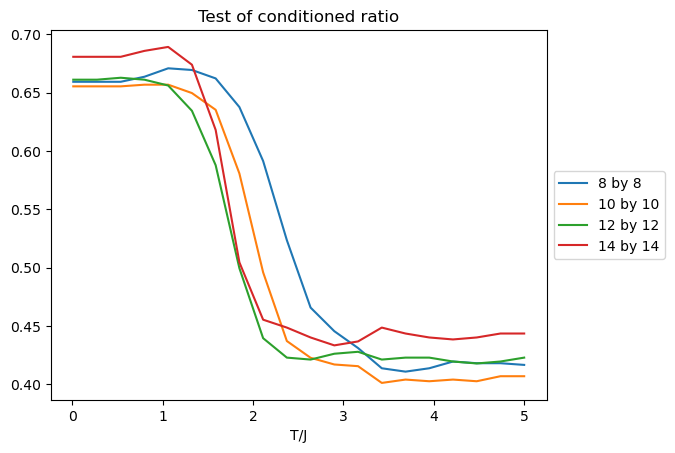

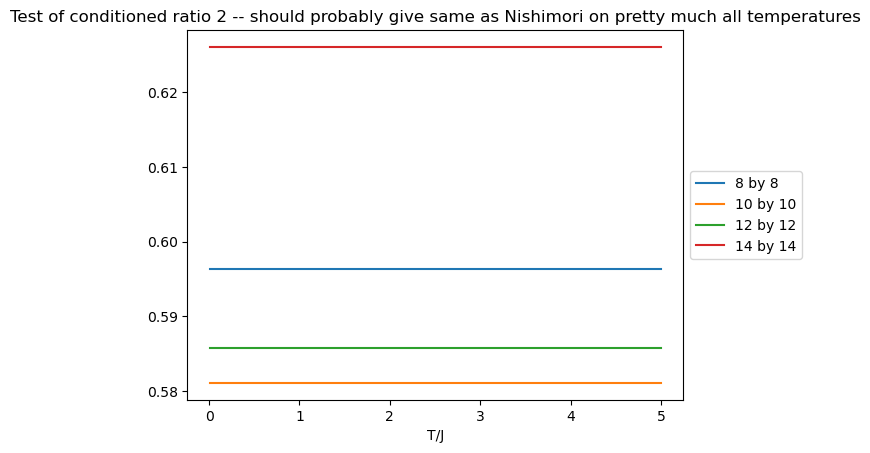

In [13]:
#Done for each f_class (meaning for each seed). Then we average later, when plotting

#In the ratios we do not use j but rather j_Nish,
#with j_Nish being whichever index gets us the Nishimori temperature
#(later, we should compute exactly at the Nishimori point to compare)


#This should in general not agree with the Preskill method away from the Nishimori line
def fractions(f_class):
    res = []
    
    for j in range(len(f_class[0])):
        
        #If condition determines if we are in the equivalence class the dedcoder chooses            
        if f_class[0][j]>f_class[1][j] and f_class[0][j]>f_class[2][j] and f_class[0][j]>f_class[3][j]:
            
            
            result = (1/(1+ mp.exp(f_class[1][j_Nish] - f_class[0][j_Nish])\
                          +mp.exp(f_class[2][j_Nish] - f_class[0][j_Nish])\
                          +mp.exp(f_class[3][j_Nish] - f_class[0][j_Nish])))
        else:
            result = (-(mp.exp(f_class[1][j_Nish] - f_class[0][j_Nish])\
                          +mp.exp(f_class[2][j_Nish] - f_class[0][j_Nish])\
                          +mp.exp(f_class[3][j_Nish] - f_class[0][j_Nish]))
                      /(1 + mp.exp(f_class[1][j_Nish] - f_class[0][j_Nish])\
                          +mp.exp(f_class[2][j_Nish] - f_class[0][j_Nish])\
                          +mp.exp(f_class[3][j_Nish] - f_class[0][j_Nish])))
        res.append(result)
    return res



def fractions_new(f_class):
    res = []
    
    for j in range(len(f_class[0])):
    
        #Decoder picks a class based on temperature j
        classes = [f_class[0][j],f_class[0][j],f_class[0][j],f_class[0][j]]

        i_max = classes.index(max(classes))

        #We find the likelihood of actually being in that class (Makes sense only for Nishimori)
        result = (1/(mp.exp(f_class[0][j_Nish] - f_class[i_max][j_Nish])\
                      + mp.exp(f_class[1][j_Nish] - f_class[i_max][j_Nish])\
                      +mp.exp(f_class[2][j_Nish] - f_class[i_max][j_Nish])\
                      +mp.exp(f_class[3][j_Nish] - f_class[i_max][j_Nish])))

        res.append(result)
    return res





def fraction_new(f_class):
    
    #Decoder picks a class based on temperature j
    classes = [f_class[0][j],f_class[0][j],f_class[0][j],f_class[0][j]]

    i_max = classes.index(max(classes))

    #We find the likelihood of actually being in that class (Makes sense only for Nishimori)
    result = (1/(mp.exp(f_class[0][j_Nish] - f_class[i_max][j_Nish])\
                  + mp.exp(f_class[1][j_Nish] - f_class[i_max][j_Nish])\
                  +mp.exp(f_class[2][j_Nish] - f_class[i_max][j_Nish])\
                  +mp.exp(f_class[3][j_Nish] - f_class[i_max][j_Nish])))

    
    return result



temperatures = np.linspace(0.01,max_temp,20)

plt.figure() 
plt.plot(temperatures,  [ 0.5 + 0.5 * np.sum([ fractions(f_class)[j]
                                   for f_class in free_energies_8 ])/len(free_energies_8)  \
                        for j in range(len(f_class[0]))], label="8 by 8")

plt.plot(temperatures,  [ 0.5 + 0.5 * np.sum([ fractions(f_class)[j]
                                   for f_class in free_energies_10 ])/len(free_energies_10)  \
                        for j in range(len(f_class[0]))], label="10 by 10")

plt.plot(temperatures,  [ 0.5 + 0.5 * np.sum([ fractions(f_class)[j]
                                   for f_class in free_energies_12 ])/len(free_energies_12)  \
                        for j in range(len(f_class[0]))], label="12 by 12")

plt.plot(temperatures,  [ 0.5 + 0.5 * np.sum([ fractions(f_class)[j]
                                   for f_class in free_energies_14 ])/len(free_energies_14)  \
                        for j in range(len(f_class[0]))], label="14 by 14")


plt.title("Test of conditioned ratio")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#Test of conditioned ratio 2 -- this one should *definitely* not work outside of
#the Nishimori line, it would just give the same result (in most cases) as on the line
plt.figure() 
plt.plot(temperatures,  [mp.fsum([ fractions_new(f_class)[j]
                                   for f_class in free_energies_8 ])/len(free_energies_8)  \
                        for j in range(len(f_class[0]))], label="8 by 8")

plt.plot(temperatures,  [mp.fsum([ fractions_new(f_class)[j]
                                   for f_class in free_energies_10 ])/len(free_energies_10)  \
                        for j in range(len(f_class[0]))], label="10 by 10")

plt.plot(temperatures,  [mp.fsum([ fractions_new(f_class)[j]
                                   for f_class in free_energies_12 ])/len(free_energies_12)  \
                        for j in range(len(f_class[0]))], label="12 by 12")

plt.plot(temperatures,  [mp.fsum([ fractions_new(f_class)[j]
                                   for f_class in free_energies_14 ])/len(free_energies_14)  \
                        for j in range(len(f_class[0]))], label="14 by 14")


plt.title("Test of conditioned ratio 2 -- should probably give same as Nishimori on pretty much all temperatures")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



In [14]:
#sanity check that math is mathing, i.,e. that the Z(E,e) dominant curve should also go to 1/4
randvals = np.random.rand(1000000,4)
print(sum([randvals[i][0]>randvals[i][1] or randvals[i][0]>randvals[i][2] or randvals[i][0]>randvals[i][3]\
           for i in range(len(randvals))])/len(randvals))
print(sum([randvals[i][0]<randvals[i][1] and randvals[i][0]<randvals[i][2] and randvals[i][0]<randvals[i][3]\
           for i in range(len(randvals))])/len(randvals))

print(1/(1+1+1+1))


#Next, if trivial class is twice as likely as the other, what do we get?
print(sum([2*randvals[i][0]>randvals[i][1] or 2*randvals[i][0]>randvals[i][2] or 2*randvals[i][0]>randvals[i][3]\
           for i in range(len(randvals))])/len(randvals))
print(sum([2*randvals[i][0]<randvals[i][1] and 2*randvals[i][0]<randvals[i][2] and 2*randvals[i][0]<randvals[i][3]\
           for i in range(len(randvals))])/len(randvals))

print(2/(2+1+1+1))


print('\n')


#sanity check that math is mathing, i.,e. that the Z(E,e) dominant curve should also go to 1/4
randvals = np.random.rand(10000000,2)
print(sum([randvals[i][0]>randvals[i][1] \
           for i in range(len(randvals))])/len(randvals))
print(sum([randvals[i][0]<randvals[i][1] \
           for i in range(len(randvals))])/len(randvals))

print(1/(1+1))


#Next, if trivial class is twice as likely as the other, what do we get?
print(sum([2*randvals[i][0]>randvals[i][1]\
           for i in range(len(randvals))])/len(randvals))
print(sum([2*randvals[i][0]<randvals[i][1]\
           for i in range(len(randvals))])/len(randvals))

print(2/(2+1))

print(sum([2*randvals[i][0]/(2*randvals[i][0] + randvals[i][1])\
           for i in range(len(randvals))])/len(randvals))

print(sum([randvals[i][1]/(2*randvals[i][0] + randvals[i][1])\
           for i in range(len(randvals))])/len(randvals))


print(sum([2*randvals[i][0] for i in range(len(randvals))])/sum([2*randvals[i][0]+randvals[i][1] for i in range(len(randvals))]) )

print(sum([randvals[i][1] for i in range(len(randvals))])/sum([2*randvals[i][0]+randvals[i][1] for i in range(len(randvals))]) )

0.749924
0.250076
0.25
0.87505
0.12495
0.4


0.4999874
0.5000126
0.5
0.7500901
0.2499099
0.6666666666666666
0.6307621185489066
0.3692378814510495
0.6666560875114521
0.3333439124887248


In [15]:
print(7*4*20/60)

#at 4:33: seed 128 for probability 0.
#at 5:25: seed 133, but had been stuck for a while probably.

9.333333333333334


In [16]:
for p in [0,0.02,0.04,0.06,0.08,0.1,0.12]:
    if p == 0:
        T_Nish = 1e-10 #avoid zero division
    else:
        T_Nish = 1/(mp.log((1-p)/p)/2)        
    print(T_Nish)

1e-10
0.51389834236975069304
0.62931596088824973365
0.72686692063163383541
0.81888444641023926992
0.91023922662683739361
1.0037992976837764127


# Looking at a range of probabilities, and comparing to pymatching

In [26]:
from PyMatching import *

num_shots = 50000
Ls = [4,6]
ps = np.linspace(0.01, 0.12, 11)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for error_probability in ps:
        num_errors = num_decoding_failures_vectorised(Hx, logX, error_probability, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=6...


In [256]:
batch_results = []

probabilities = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12]

#probabilities = [0.01,0.12]

for p in probabilities:
    
    print('Probability',p)
    
    
    seed_range = range(100,401)
    
    
    
    #Taking more shots at low p for better resolution at log scale
    if p in [0.01,0.02,0.03]:
        seed_range = range(100,601)
        
    if p in [0.01,0.02]:
        seed_range = range(100,801)
        
    if p in [0.01]:
        seed_range = range(100,981)
 


    #...and a few more at high p for lin scale resolution
    if p in [0.12]:
        seed_range = range(100,501)

        
    batch_res_4 = []

    for seed in seed_range:
        res = []
        all_good = True

        try:
            for error in ["I","X","Y","Z"]:
                filename = "../results/periodic/prob_%6f"%p+"/X_4_Y_4/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_10000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
                
                res.append(read_data_from_file(filename))
        except:
            print('One or more error classes at 4 by 4 had an issue for seed',seed,'at probability',p)
            all_good = False

        if all_good:
            batch_res_4.append(res)
    
    batch_res_6 = []
    for seed in seed_range:
        res = []
        all_good = True

        try:
            for error in ["I","X","Y","Z"]:
                filename = "../results/periodic/prob_%6f"%p+"/X_6_Y_6/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_10000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"

                res.append(read_data_from_file(filename))
        except:
            print('One or more error classes at 6 by 6 had an issue for seed',seed,'at probability',p)
            all_good = False

        if all_good:
            batch_res_6.append(res)
            

    print('Adding to results for probability',p)
    print('Number of seeds:', len(batch_res_4), len(batch_res_6))
    rescaled_res_4 = process_results(batch_res_4,4,4)
    rescaled_res_6 = process_results(batch_res_6,6,6)
    batch_results.append([rescaled_res_4,rescaled_res_6])

Probability 0.01
Adding to results for probability 0.01
Number of seeds: 881 881
Probability 0.02
Adding to results for probability 0.02
Number of seeds: 701 701
Probability 0.03
Adding to results for probability 0.03
Number of seeds: 501 501
Probability 0.04
Adding to results for probability 0.04
Number of seeds: 301 301
Probability 0.05
Adding to results for probability 0.05
Number of seeds: 301 301
Probability 0.06
Adding to results for probability 0.06
Number of seeds: 301 301
Probability 0.07
Adding to results for probability 0.07
Number of seeds: 301 301
Probability 0.08
Adding to results for probability 0.08
Number of seeds: 301 301
Probability 0.09
Adding to results for probability 0.09
Number of seeds: 301 301
Probability 0.1
Adding to results for probability 0.1
Number of seeds: 301 301
Probability 0.11
Adding to results for probability 0.11
Number of seeds: 301 301
Probability 0.12
Adding to results for probability 0.12
Number of seeds: 401 401


In [257]:
free_energies_batch = []


for i, p in enumerate(probabilities):
    
    print('Probability',p)
    
    if p == 0:
        T_Nish = 0
    else:
        T_Nish = 1/(mp.log((1-p)/p)/2)  
        
    temperatures = [1e-10,T_Nish,1e10]
    
    #would need a separate function for the p=0 case, and probably won't consider p=0.
    if len(batch_results)>=i+1 and p>0:
        
        free_energies_4 = get_free_energies(batch_results[i][0],temperatures)
        free_energies_6 = get_free_energies(batch_results[i][1],temperatures)
        free_energies_batch.append([free_energies_4,free_energies_6])
        

Probability 0.01
Probability 0.02
Probability 0.03
Probability 0.04
Probability 0.05
Probability 0.06
Probability 0.07
Probability 0.08
Probability 0.09
Probability 0.1
Probability 0.11
Probability 0.12


In [258]:
def experimental_fraction(f_class, j):
    
    #If condition determines if we are in the equivalence class the dedcoder chooses

    if f_class[0][j]>f_class[1][j] and f_class[0][j]>f_class[2][j] and f_class[0][j]>f_class[3][j]:

        result = (1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                      +mp.exp(f_class[2][j] - f_class[0][j])\
                      +mp.exp(f_class[3][j] - f_class[0][j])))
    else:
        result = (-(mp.exp(f_class[1][j] - f_class[0][j])\
                      +mp.exp(f_class[2][j] - f_class[0][j])\
                      +mp.exp(f_class[3][j] - f_class[0][j]))
                  /(1 + mp.exp(f_class[1][j] - f_class[0][j])\
                      +mp.exp(f_class[2][j] - f_class[0][j])\
                      +mp.exp(f_class[3][j] - f_class[0][j])))
    return result


#j=1 is assumed to correspond to the Nishimori temperature
def experimental_fraction_new(f_class, j):
    
    #Decoder picks a class based on temperature j
    classes = [f_class[0][j],f_class[1][j],f_class[2][j],f_class[3][j]]

    i_max = classes.index(max(classes))
    
    #We find the likelihood of actually being in that class (Makes sense only for Nishimori)
    #Here, convention is that j=1 is Nishimori, j=0 is T=0, other temperatures are j>1
    result = (1/(mp.exp(f_class[0][1] - f_class[i_max][1])\
                  + mp.exp(f_class[1][1] - f_class[i_max][1])\
                  +mp.exp(f_class[2][1] - f_class[i_max][1])\
                  +mp.exp(f_class[3][1] - f_class[i_max][1])))

    
    return result



optimal_curve = []
mwpm_curve = []

order_probability = []
order_probability_T0 = []

experimental_curve = []
experimental_curve_T0 = []

experimental_curve_new = []
experimental_curve_new_T0 = []



Preskill_curve_highT = []
order_probability_highT = []
experimental_curve_highT = []
experimental_curve_new_highT = []


for i, p in enumerate(probabilities):
    free_energies_4 = free_energies_batch[i][0]
    free_energies_6 = free_energies_batch[i][1]
    
    
    j = 1
    res1 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_4 ])/len(free_energies_4) 

    res2 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
    
    order_probability.append([res1,res2])
    
    
    j = 0
    res1 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_4 ])/len(free_energies_4) 

    res2 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
    
    order_probability_T0.append([res1,res2])
    
    
    j = 2
    res1 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_4 ])/len(free_energies_4) 

    res2 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
    
    order_probability_highT.append([res1,res2])
    
    
    j = 1
    res1 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_4])/(len(free_energies_4))


    res2 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_6])/(len(free_energies_6))

    optimal_curve.append([res1,res2])
    
    
    j = 0
    res1 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_4])/(len(free_energies_4))


    res2 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_6])/(len(free_energies_6))

    mwpm_curve.append([res1,res2])
    
    
    j = 2
    res1 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_4])/(len(free_energies_4))


    res2 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_6])/(len(free_energies_6))

    Preskill_curve_highT.append([res1,res2])
    
    
        
    j = 1
    res1 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
        
    experimental_curve_new.append([res1,res2])

    
    j = 0
    res1 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
        
    experimental_curve_new_T0.append([res1,res2])
    
    
    
    j = 2
    res1 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
        
    experimental_curve_new_highT.append([res1,res2])
    
    
    
    
    j = 1
    res1 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
        
    experimental_curve.append([res1,res2])

    
    j = 0
    res1 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
        
    experimental_curve_T0.append([res1,res2])
    
    j = 2
    res1 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
        
    experimental_curve_highT.append([res1,res2])

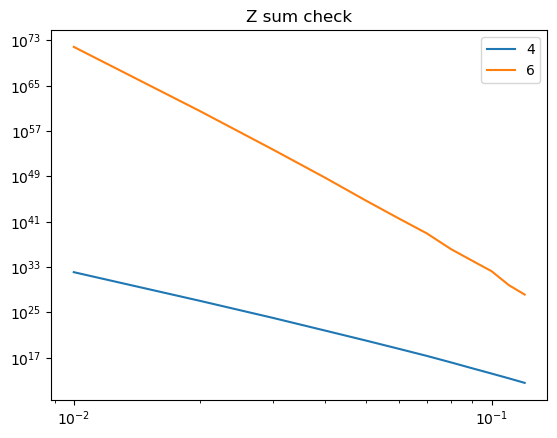

In [259]:
Z_sum_check = []

for i, p in enumerate(probabilities):
    free_energies_4 = free_energies_batch[i][0]
    free_energies_6 = free_energies_batch[i][1]
    
    j = 1

    res1 = mp.fsum([mp.exp(f_class[0][j])+ mp.exp(f_class[1][j])\
                          +mp.exp(f_class[2][j])+mp.exp(f_class[3][j]) \
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = mp.fsum([mp.exp(f_class[0][j])+ mp.exp(f_class[1][j])\
                          +mp.exp(f_class[2][j])+mp.exp(f_class[3][j]) \
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
    Z_sum_check.append([res1,res2])
    
    
plt.figure
plt.plot(probabilities, Z_sum_check,label=["4","6"])
plt.title("Z sum check")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

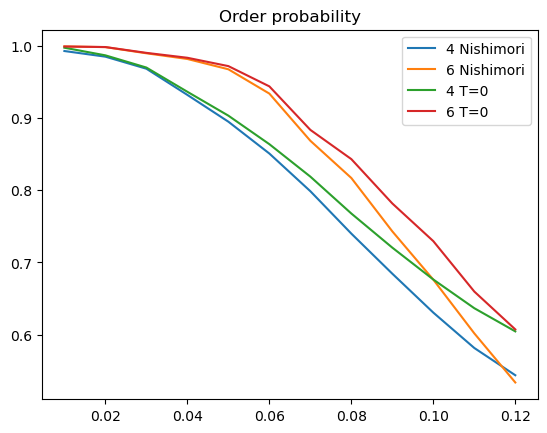

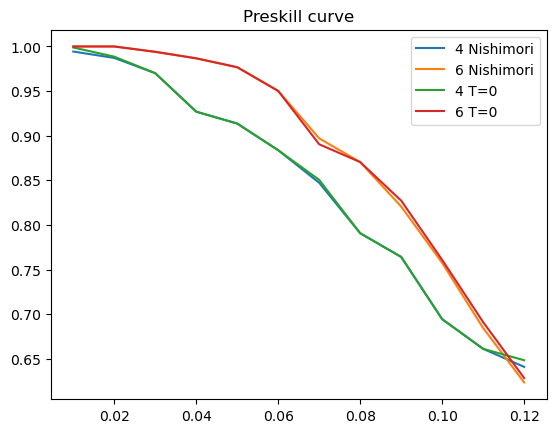

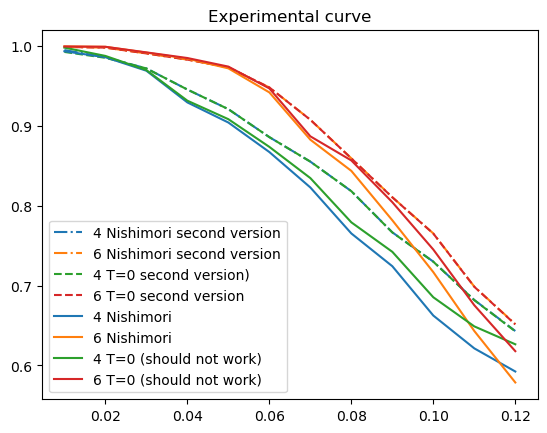

In [260]:
plt.figure
plt.plot(probabilities, order_probability,label=["4 Nishimori","6 Nishimori"])
plt.plot(probabilities, order_probability_T0,label=["4 T=0","6 T=0"])

plt.title("Order probability")
plt.legend()
plt.show()
             
plt.figure
plt.plot(probabilities, optimal_curve,label=["4 Nishimori","6 Nishimori"])
plt.plot(probabilities, mwpm_curve,label=["4 T=0","6 T=0"])

plt.title("Preskill curve")
plt.legend()
plt.show()

plt.figure
plt.plot(probabilities, experimental_curve_new,"-.",label=["4 Nishimori second version","6 Nishimori second version"])
plt.plot(probabilities, experimental_curve_new_T0,"--",label=["4 T=0 second version)","6 T=0 second version"])
plt.gca().set_prop_cycle(None)
plt.plot(probabilities, experimental_curve,label=["4 Nishimori","6 Nishimori "])
plt.plot(probabilities, experimental_curve_T0,label=["4 T=0 (should not work)","6 T=0 (should not work)"])


plt.title("Experimental curve")
plt.legend()
plt.show()


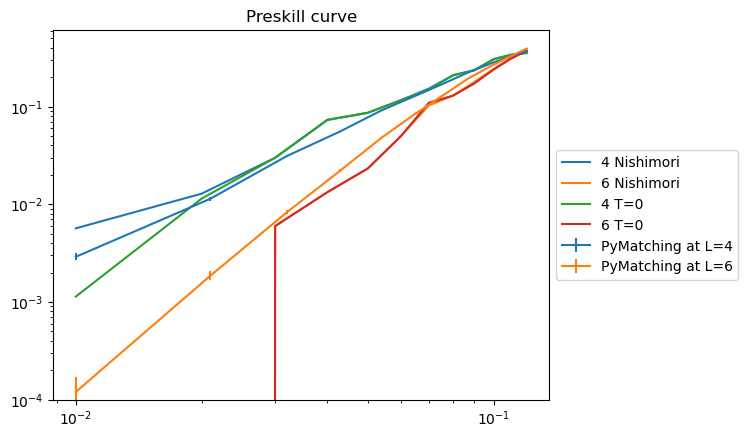

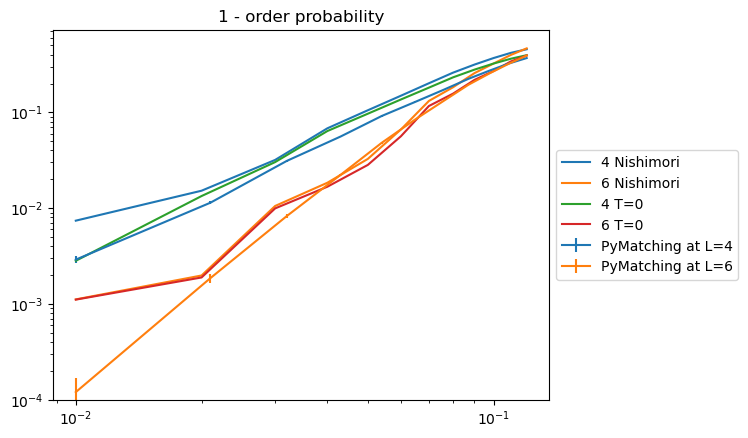

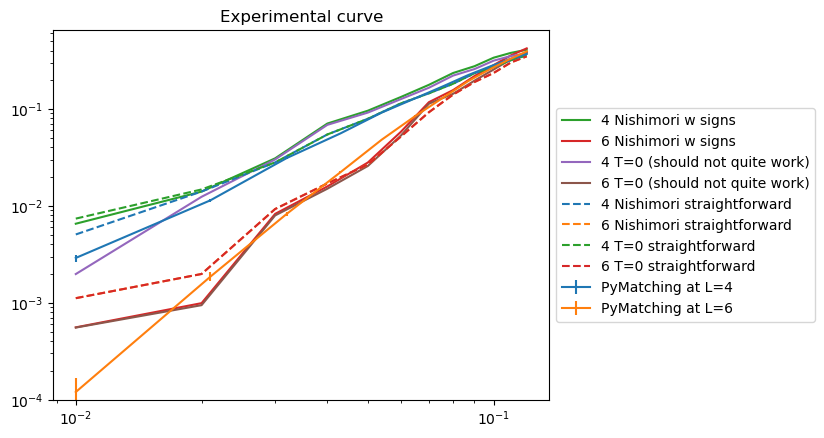

In [261]:

plt.figure

for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))
    
plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(optimal_curve))],label="4 Nishimori")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(optimal_curve))],label="6 Nishimori")
plt.plot(probabilities, [1-mwpm_curve[j][0] for j in range(len(optimal_curve))], label= "4 T=0")
plt.plot(probabilities, [1-mwpm_curve[j][1] for j in range(len(optimal_curve))], label= "6 T=0")


plt.title("Preskill curve")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()



plt.figure
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))
    
plt.gca().set_prop_cycle(None)

    
plt.plot(probabilities, [1-order_probability[j][0] for j in range(len(order_probability))],label="4 Nishimori")
plt.plot(probabilities, [1-order_probability[j][1] for j in range(len(order_probability))],label="6 Nishimori")
plt.plot(probabilities, [1-order_probability_T0[j][0] for j in range(len(order_probability))], label = "4 T=0")
plt.plot(probabilities, [1-order_probability_T0[j][1] for j in range(len(order_probability))], label = "6 T=0")


plt.title("1 - order probability")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()


plt.figure
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))
    
    

plt.plot(probabilities, [1-experimental_curve[j][0] for j in range(len(experimental_curve))],label="4 Nishimori w signs")
plt.plot(probabilities, [1-experimental_curve[j][1] for j in range(len(experimental_curve))],label="6 Nishimori w signs")
plt.plot(probabilities, [1-experimental_curve_T0[j][0] for j in range(len(experimental_curve))],label="4 T=0 (should not quite work)")
plt.plot(probabilities, [1-experimental_curve_T0[j][1] for j in range(len(experimental_curve))],label="6 T=0 (should not quite work)")
plt.gca().set_prop_cycle(None)
plt.plot(probabilities, [1-experimental_curve_new[j][0] for j in range(len(experimental_curve))],"--",label="4 Nishimori straightforward")
plt.plot(probabilities, [1-experimental_curve_new[j][1] for j in range(len(experimental_curve))],"--",label="6 Nishimori straightforward")
plt.plot(probabilities, [1-experimental_curve_new_T0[j][0] for j in range(len(experimental_curve))],"--",label="4 T=0 straightforward")
plt.plot(probabilities, [1-experimental_curve_new_T0[j][1] for j in range(len(experimental_curve))],"--",label="6 T=0 straightforward")


plt.title("Experimental curve")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()


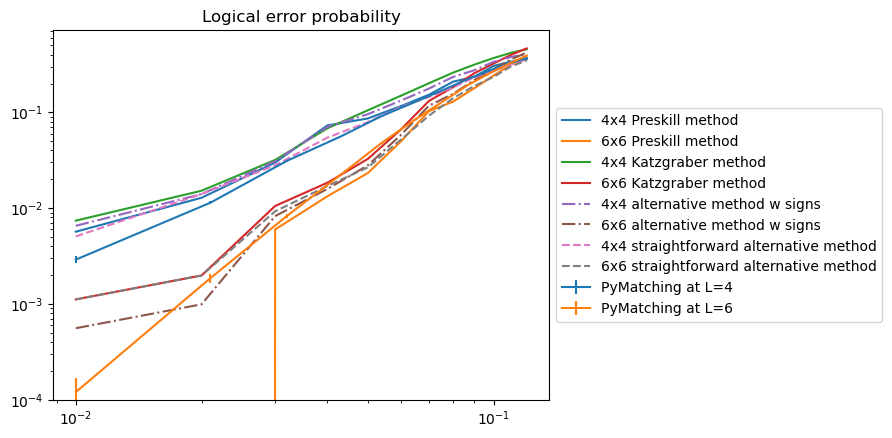

In [262]:
plt.figure


# plt.plot(probabilities, [p for p in probabilities],"--",color="black",label="Break-even")
# plt.plot(probabilities, [30*p**2 for p in probabilities],"--",color="gray",label="4 expected slope")
# plt.plot(probabilities, [150*p**3 for p in probabilities],"-.",color="gray",label="6 expected slope")


for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))
    
plt.gca().set_prop_cycle(None)




plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(optimal_curve))],label="4x4 Preskill method")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(optimal_curve))],label="6x6 Preskill method")

#plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-order_probability[j][0] for j in range(len(order_probability))],label="4x4 Katzgraber method")
plt.plot(probabilities, [1-order_probability[j][1] for j in range(len(order_probability))],label="6x6 Katzgraber method")

#plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-experimental_curve[j][0] for j in range(len(experimental_curve))],'-.',label="4x4 alternative method w signs")
plt.plot(probabilities, [1-experimental_curve[j][1] for j in range(len(experimental_curve))],'-.',label="6x6 alternative method w signs")

#plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-experimental_curve_new[j][0] for j in range(len(experimental_curve))],"--",label="4x4 straightforward alternative method")
plt.plot(probabilities, [1-experimental_curve_new[j][1] for j in range(len(experimental_curve))],"--",label="6x6 straightforward alternative method")



plt.title("Logical error probability")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()


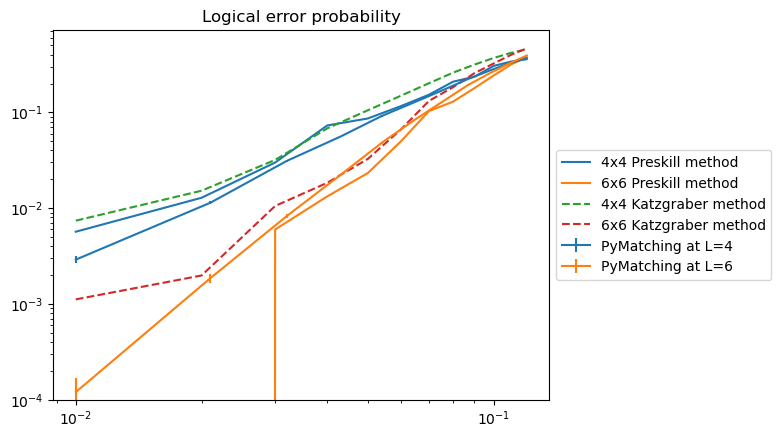

In [263]:
plt.figure


for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))
    
plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(optimal_curve))],label="4x4 Preskill method")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(optimal_curve))],label="6x6 Preskill method")

plt.plot(probabilities, [1-order_probability[j][0] for j in range(len(order_probability))],"--",label="4x4 Katzgraber method")
plt.plot(probabilities, [1-order_probability[j][1] for j in range(len(order_probability))],"--",label="6x6 Katzgraber method")


plt.title("Logical error probability")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()


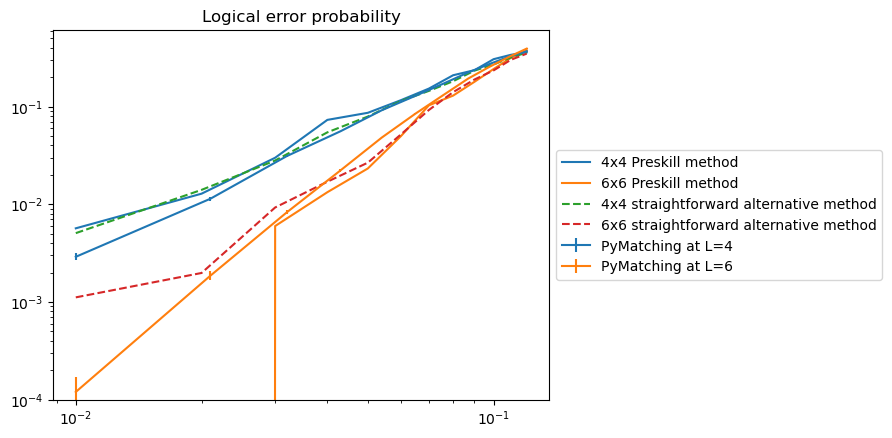

In [264]:
plt.figure


for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))
    
plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(optimal_curve))],label="4x4 Preskill method")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(optimal_curve))],label="6x6 Preskill method")

plt.plot(probabilities, [1-experimental_curve_new[j][0] for j in range(len(experimental_curve))],"--",label="4x4 straightforward alternative method")
plt.plot(probabilities, [1-experimental_curve_new[j][1] for j in range(len(experimental_curve))],"--",label="6x6 straightforward alternative method")

plt.title("Logical error probability")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()

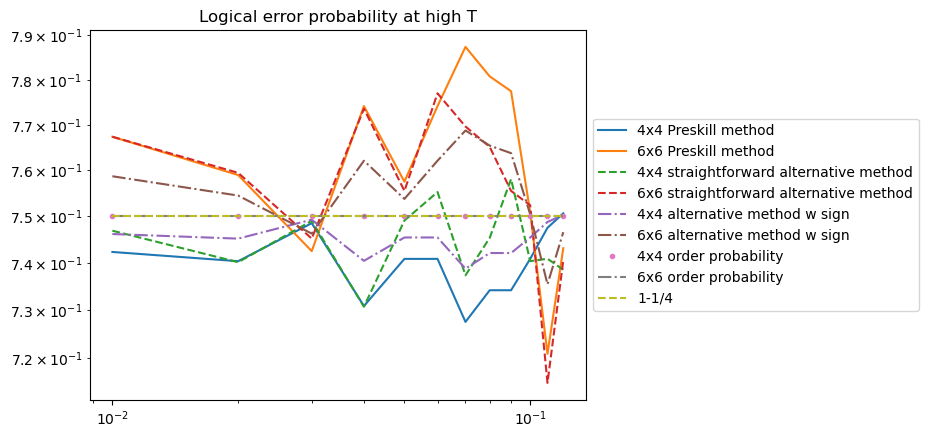

In [265]:
plt.figure


plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-Preskill_curve_highT[j][0] for j in range(len(optimal_curve))],label="4x4 Preskill method")
plt.plot(probabilities, [1-Preskill_curve_highT[j][1] for j in range(len(optimal_curve))],label="6x6 Preskill method")

plt.plot(probabilities, [1-experimental_curve_new_highT[j][0] for j in range(len(experimental_curve))],"--",label="4x4 straightforward alternative method")
plt.plot(probabilities, [1-experimental_curve_new_highT[j][1] for j in range(len(experimental_curve))],"--",label="6x6 straightforward alternative method")



plt.plot(probabilities, [1-experimental_curve_highT[j][0] for j in range(len(experimental_curve))],"-.",label="4x4 alternative method w sign")
plt.plot(probabilities, [1-experimental_curve_highT[j][1] for j in range(len(experimental_curve))],"-.",label="6x6 alternative method w sign")


plt.plot(probabilities, [1-order_probability_highT[j][0] for j in range(len(experimental_curve))],".",label="4x4 order probability")
plt.plot(probabilities, [1-order_probability_highT[j][1] for j in range(len(experimental_curve))],"-.",label="6x6 order probability")

plt.plot(probabilities,[1-1/4 for j in range(len(probabilities))],"--", label="1-1/4")


plt.title("Logical error probability at high T")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

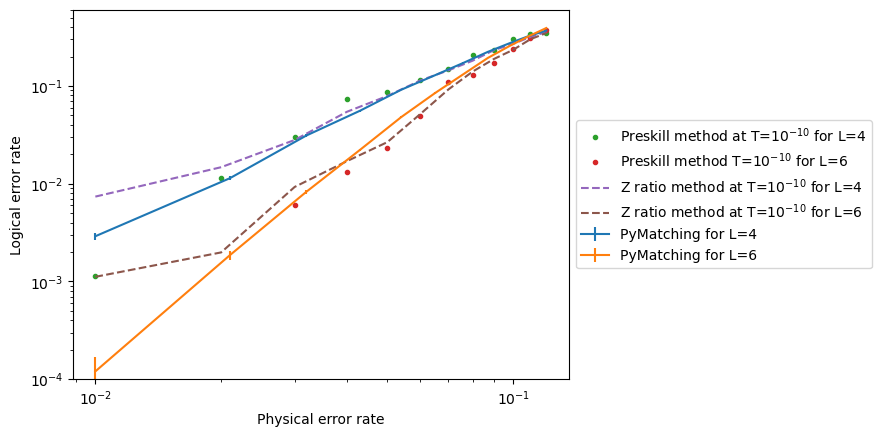

In [269]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching for L={}".format(L))
    
    
    
plt.plot(probabilities, [1-mwpm_curve[j][0] for j in range(len(experimental_curve))],".",label=r"Preskill method at T=$10^{-10}$ for L=4")
plt.plot(probabilities, [1-mwpm_curve[j][1] for j in range(len(experimental_curve))],".",label=r"Preskill method T=$10^{-10}$ for L=6")





plt.plot(probabilities, [1-experimental_curve_new_T0[j][0] for j in range(len(experimental_curve))],"--",label=r"Z ratio method at T=$10^{-10}$ for L=4")
plt.plot(probabilities, [1-experimental_curve_new_T0[j][1] for j in range(len(experimental_curve))],"--",label=r"Z ratio method at T=$10^{-10}$ for L=6")





# plt.plot(probabilities, [1-order_probability_T0[j][0] for j in range(len(experimental_curve))],"-.",label="Order prob. method at T=0 for L=4")
# plt.plot(probabilities, [1-order_probability_T0[j][1] for j in range(len(experimental_curve))],"-.",label="Order prob method at T=0 for L=6")




plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")

plt.xscale('log')
plt.yscale('log')
plt.ylim(bottom=1e-4, top=None)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

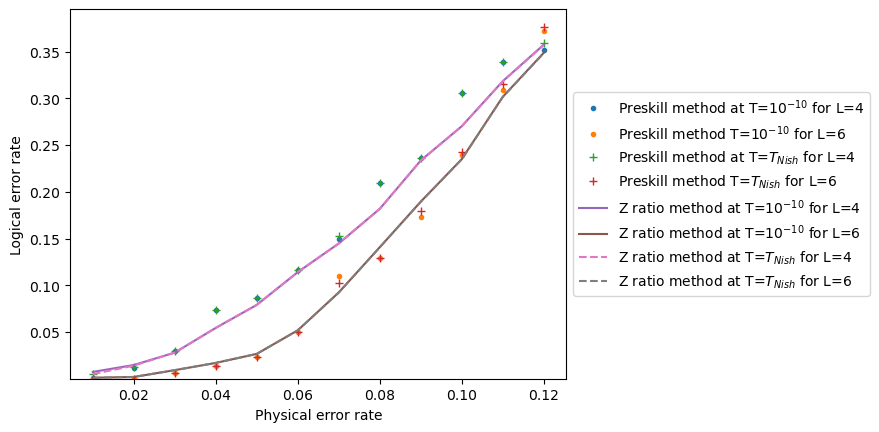

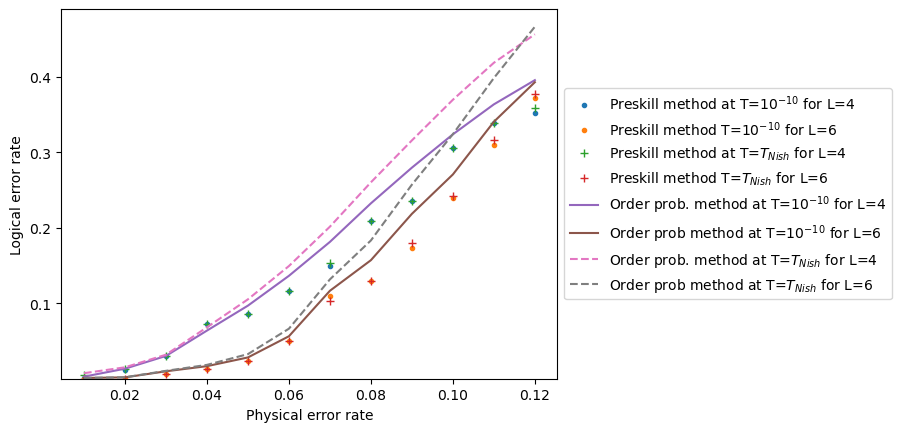

In [270]:
plt.figure()
 
plt.plot(probabilities, [1-mwpm_curve[j][0] for j in range(len(experimental_curve))],".",label=r"Preskill method at T=$10^{-10}$ for L=4")
plt.plot(probabilities, [1-mwpm_curve[j][1] for j in range(len(experimental_curve))],".",label=r"Preskill method T=$10^{-10}$ for L=6")

    
plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(experimental_curve))],"+",label=r"Preskill method at T=$T_{Nish}$ for L=4")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(experimental_curve))],"+",label=r"Preskill method T=$T_{Nish}$ for L=6")

    
plt.plot(probabilities, [1-experimental_curve_new_T0[j][0] for j in range(len(experimental_curve))],label=r"Z ratio method at T=$10^{-10}$ for L=4")
plt.plot(probabilities, [1-experimental_curve_new_T0[j][1] for j in range(len(experimental_curve))],label=r"Z ratio method at T=$10^{-10}$ for L=6")


plt.plot(probabilities, [1-experimental_curve_new[j][0] for j in range(len(experimental_curve))],"--",label=r"Z ratio method at T=$T_{Nish}$ for L=4")
plt.plot(probabilities, [1-experimental_curve_new[j][1] for j in range(len(experimental_curve))],"--",label=r"Z ratio method at T=$T_{Nish}$ for L=6")


plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")


plt.ylim(bottom=1e-4, top=None)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()





plt.figure()

plt.plot(probabilities, [1-mwpm_curve[j][0] for j in range(len(experimental_curve))],".",label=r"Preskill method at T=$10^{-10}$ for L=4")
plt.plot(probabilities, [1-mwpm_curve[j][1] for j in range(len(experimental_curve))],".",label=r"Preskill method T=$10^{-10}$ for L=6")

    
plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(experimental_curve))],"+",label=r"Preskill method at T=$T_{Nish}$ for L=4")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(experimental_curve))],"+",label=r"Preskill method T=$T_{Nish}$ for L=6")



plt.plot(probabilities, [1-order_probability_T0[j][0] for j in range(len(experimental_curve))],label=r"Order prob. method at T=$10^{-10}$ for L=4")
plt.plot(probabilities, [1-order_probability_T0[j][1] for j in range(len(experimental_curve))],label=r"Order prob method at T=$10^{-10}$ for L=6")


plt.plot(probabilities, [1-order_probability[j][0] for j in range(len(experimental_curve))],"--",label=r"Order prob. method at T=$T_{Nish}$ for L=4")
plt.plot(probabilities, [1-order_probability[j][1] for j in range(len(experimental_curve))],"--",label=r"Order prob method at T=$T_{Nish}$ for L=6")


plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")


plt.ylim(bottom=1e-4, top=None)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()